In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

In [2]:
import torch
from torch import nn
from torch.nn.init import calculate_gain
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [4]:
from models.Wang2020 import M4_1
from torchinfo import summary
net = M4_1(N_layers=8, width=32, alpha=0.9, activation=nn.Softplus(30), last_activation=nn.Identity()).to(device)

Layer (type:depth-idx)                   Param #
M4_1                                     --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       128
│    └─Linear: 2-2                       128
│    └─Linear: 2-3                       128
│    └─Linear: 2-4                       1,056
│    └─Linear: 2-5                       1,056
│    └─Linear: 2-6                       1,056
│    └─Linear: 2-7                       1,056
│    └─Linear: 2-8                       1,056
│    └─Linear: 2-9                       1,056
│    └─Linear: 2-10                      1,056
│    └─Linear: 2-11                      1,056
│    └─Linear: 2-12                      33
├─Softplus: 1-2                          --
├─Identity: 1-3                          --
├─MSELoss: 1-4                           --
Total params: 8,865
Trainable params: 8,865
Non-trainable params: 0

In [5]:
import os
from utils.dataset import ImplicitDataset, RandomMeshSDFDataset, batch_loader

dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
train_dataset = ImplicitDataset.from_file(file=dataset_name+'_train.npz', device=device)
#train_dataset = RandomMeshSDFDataset(output_stl, sampling_method='importance', M=int(1e6), W=10, device=device)
print(train_dataset)

ImplicitDataset (19683 points)


In [6]:
from utils.optimizer import CallbackScheduler

# Optimization
## ADA
optimizer=torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.reduce_lr(0.1),
    CallbackScheduler.reduce_lr(0.5),
    CallbackScheduler.reduce_lr(0.5),
], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [9]:
#torch.autograd.set_detect_anomaly(True)
max_epochs = 2500
PRINT_EVERY_EPOCH = 100
epoch = 0
points = train_dataset.points
sdfs = train_dataset.sdfs
grads = train_dataset.grads
points.requires_grad_(True)
try:
    while epoch < max_epochs:
        # Training
        #for points, sdfs in batch_loader(train_dataset.points, train_dataset.sdfs, batch_size=20000): 
            lr_scheduler.optimizer.zero_grad()
            if points.grad is not None:
                points.grad.zero_()
            loss = net.loss(points, sdfs, grads)
            loss.backward()
      
            lr_scheduler.optimizer.step(lambda: loss)
            lr_scheduler.step_when((epoch % 500) == 499)
            lr_scheduler.step_loss(loss)
        
            if epoch % 100 == 99:
                net.adaptive_lambda(points, sdfs, grads)

            if epoch % PRINT_EVERY_EPOCH == 0:
                print(f'#{epoch} Loss: {net._loss_PDE:.6f}, {net._loss_SDF:.6f}, {net.loss_lambda:.6f}')
            epoch += 1
except KeyboardInterrupt as e:
    print('Bye bye')


#0 Loss: 0.040816, 0.007943, 11.182713
#100 Loss: 0.042930, 0.006910, 11.374568
#200 Loss: 0.056195, 0.003808, 11.835821
#300 Loss: 0.053033, 0.004313, 12.211482
#400 Loss: 0.041701, 0.007104, 12.238462
#500 Loss: 0.055394, 0.003956, 12.600563
#600 Loss: 0.050042, 0.004616, 12.900316
#700 Loss: 0.050147, 0.004588, 13.169433
#800 Loss: 0.050226, 0.004568, 13.410988
#900 Loss: 0.050279, 0.004551, 13.628296
#1000 Loss: 0.050324, 0.004537, 13.823484
#1100 Loss: 0.050379, 0.004525, 13.998752
#1200 Loss: 0.050428, 0.004514, 14.155956
#1300 Loss: 0.050467, 0.004505, 14.296950
#1400 Loss: 0.050497, 0.004497, 14.423409
#1500 Loss: 0.050526, 0.004489, 14.536627
#1600 Loss: 0.050556, 0.004483, 14.638159
#1700 Loss: 0.050583, 0.004477, 14.729090
#1800 Loss: 0.050608, 0.004472, 14.810446
#1900 Loss: 0.050629, 0.004467, 14.883158
#2000 Loss: 0.050647, 0.004463, 14.948088
#2100 Loss: 0.050660, 0.004459, 15.005906
#2200 Loss: 0.050670, 0.004456, 15.057388
#2300 Loss: 0.050678, 0.004453, 15.103162
#240

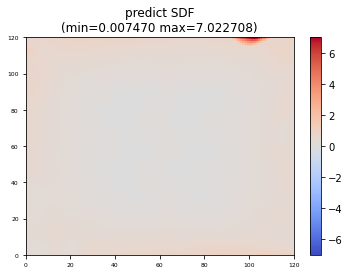

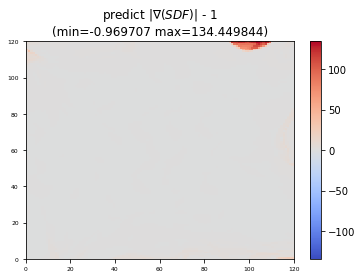

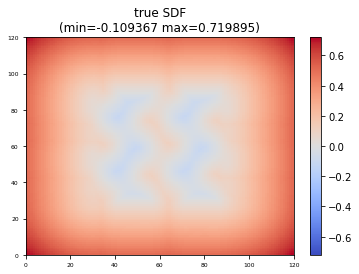

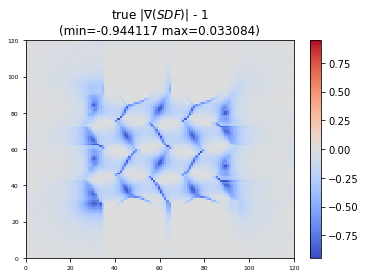

In [10]:
from utils import SDFVisualize, plot_model_weight
visualize = SDFVisualize(z_level=0.1, step=0.05, offset=30, nums=120, device=device)
visualize.from_nn(net, bounds_from_mesh=output_stl)
visualize.from_mesh(output_stl)

In [10]:
from utils.dataset import TestDataset
test_dataset = TestDataset(dataset_name+'_test.npz', device=device)
print('Uniform SDFS: ', net.test(test_dataset.uniform.points, test_dataset.uniform.sdfs).cpu().detach().numpy())
print('Uniform gradient: ', net.test_gradient(test_dataset.uniform.points, test_dataset.uniform.gradients).cpu().detach().numpy())
print('Random SDFS:', net.test(test_dataset.random.points, test_dataset.random.sdfs).cpu().detach().numpy())

Uniform SDFS:  0.0007980248
Uniform gradient:  0.06293653
Random SDFS: 0.00084954366
